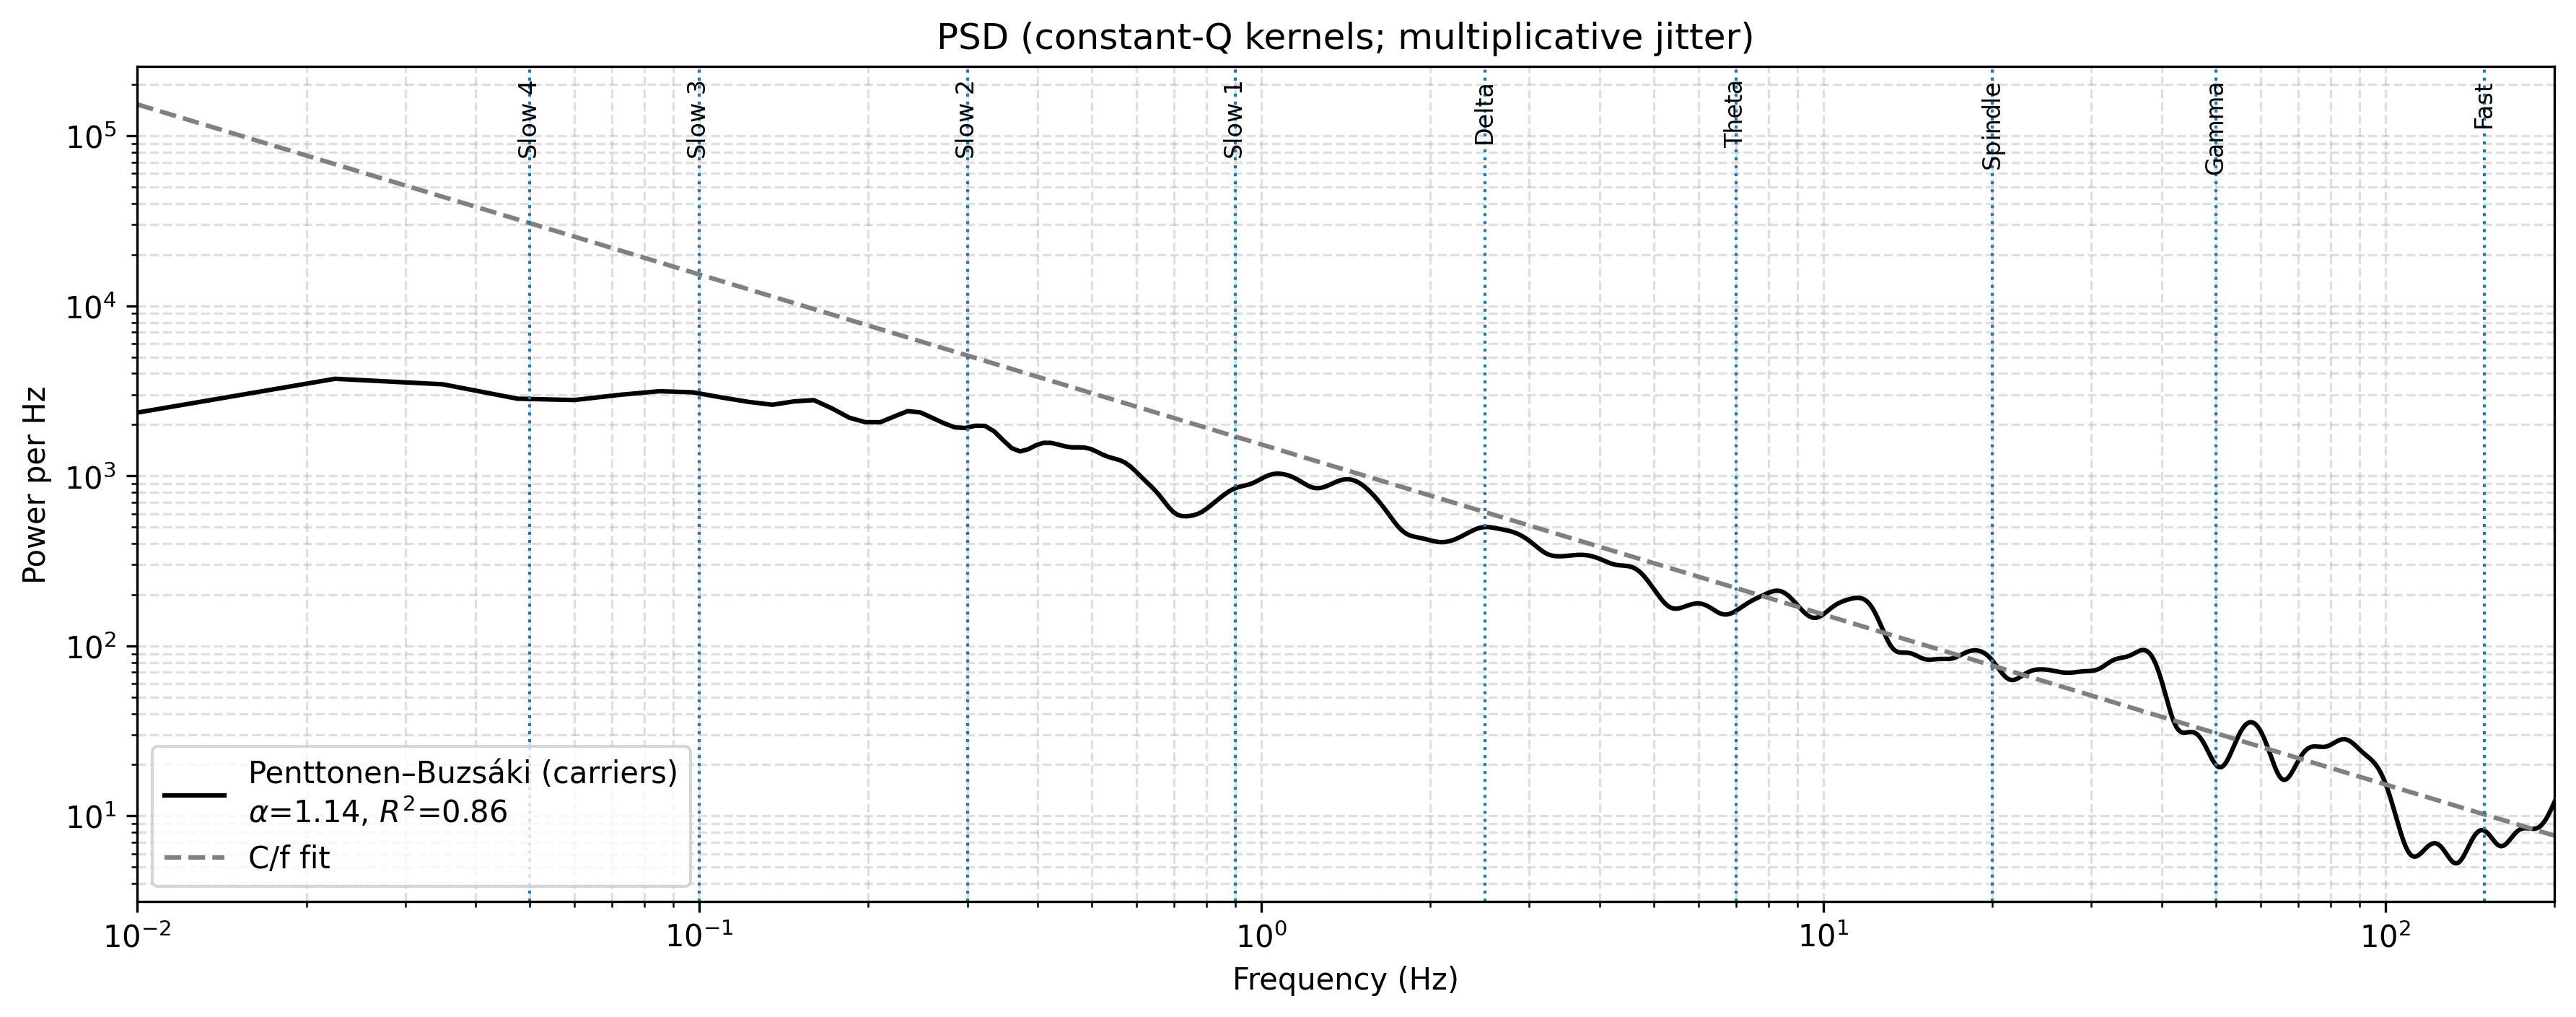

Fitted alpha (r ladder):   α ≈ 0.99, R² ≈ 0.85
Fitted alpha (Penttonen):  α ≈ 1.14, R² ≈ 0.86


In [1]:
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 300  # Adjust to your preference


# Try SciPy for the log-log fit; fall back to numpy if missing
try:
    from scipy.stats import linregress
    _HAS_SCIPY = True
except Exception:
    _HAS_SCIPY = False

# ------------------------------ Penttonen–Buzsáki bands ------------------------------
bands = [
    {"name": "Slow 4",     "number": 1, "center_frequency_hz": 0.05,  "frequency_range_hz": (0.02, 0.06)},
    {"name": "Slow 3",     "number": 2, "center_frequency_hz": 0.10,  "frequency_range_hz": (0.06, 0.20)},
    {"name": "Slow 2",     "number": 3, "center_frequency_hz": 0.30,  "frequency_range_hz": (0.20, 0.50)},
    {"name": "Slow 1",     "number": 4, "center_frequency_hz": 0.90,  "frequency_range_hz": (0.50, 1.50)},
    {"name": "Delta",      "number": 5, "center_frequency_hz": 2.50,  "frequency_range_hz": (1.50, 4.00)},
    {"name": "Theta",      "number": 6, "center_frequency_hz": 7.00,  "frequency_range_hz": (4.00, 10.0)},
    {"name": "Spindle",    "number": 7, "center_frequency_hz": 20.0,  "frequency_range_hz": (10.0, 30.0)},
    {"name": "Gamma",      "number": 8, "center_frequency_hz": 50.0,  "frequency_range_hz": (30.0, 80.0)},
    {"name": "Fast",       "number": 9, "center_frequency_hz": 150.0, "frequency_range_hz": (80.0, 200.0)},
    {"name": "Ultra-fast", "number": 10,"center_frequency_hz": 350.0, "frequency_range_hz": (200.0, 600.0)},
]

# ------------------------------ helpers ------------------------------
rng = np.random.default_rng(7)

def geometric_centers(fmin, fmax, r):
    """Geometric ladder of centers between fmin..fmax with ratio r (>1)."""
    f = [fmin]
    while f[-1] * r <= fmax:
        f.append(f[-1] * r)
    return np.array(f, dtype=float)

def penttonen_centers():
    return np.array([b["center_frequency_hz"] for b in bands], dtype=float)

def jitter_multiplicative(centers, n_copies=10, scale_range=(1.0, 3.0), amp_jitter=None):
    """
    For each base center f, create n_copies jittered versions by multiplying by s ~ U[a,b].
    Returns expanded (freqs, amps). amp_jitter can be a scalar or length=len(centers).
    """
    a, b = scale_range
    s = rng.uniform(a, b, size=(len(centers), n_copies))
    freqs = (centers[:, None] * s).ravel()
    if amp_jitter is None:
        amps = np.ones_like(freqs)
    else:
        if np.isscalar(amp_jitter):
            amps = np.full_like(freqs, float(amp_jitter))
        else:
            amp = np.array(amp_jitter, dtype=float).reshape(-1, 1)
            amps = np.broadcast_to(amp, s.shape).ravel()
    return freqs, amps

def constant_q_gaussian(freq_axis, f0, power, q=0.05):
    """
    Constant‑Q Gaussian line of *area=power* centered at f0.
    sigma = q * f0 (with a small minimum for numerical stability).
    """
    if f0 <= freq_axis[0] or f0 >= freq_axis[-1]:
        return np.zeros_like(freq_axis)
    sigma = max(q * f0, 1e-6)
    g = np.exp(-0.5 * ((freq_axis - f0) / sigma) ** 2) / (np.sqrt(2*np.pi) * sigma)
    return power * g

def spectrum_from_centers(freq_axis, centers, carrier_amps=None, m=0.5, q=0.05,
                          include_sidebands=True, fmin=None, fmax=None):
    """
    Per‑Hz spectrum with carriers (power=A_c^2) and all first‑order AM sidebands (fc±fm, fm<fc).
    Each sideband gets power ((m*A_c)/2)^2. We construct power directly (phases irrelevant).
    """
    if carrier_amps is None:
        carrier_amps = np.ones_like(centers)
    carriers = np.zeros_like(freq_axis)
    sidebands = np.zeros_like(freq_axis)

    order = np.argsort(centers)
    centers = np.array(centers, dtype=float)[order]
    carrier_amps = np.array(carrier_amps, dtype=float)[order]

    # carriers
    for fc, Ac in zip(centers, carrier_amps):
        carriers += constant_q_gaussian(freq_axis, fc, power=Ac**2, q=q)

    # sidebands
    if include_sidebands:
        fmin = freq_axis[0] if fmin is None else fmin
        fmax = freq_axis[-1] if fmax is None else fmax
        for i in range(len(centers)):
            fc, Ac = centers[i], carrier_amps[i]
            for j in range(i):                # fm < fc
                fm = centers[j]
                p = ((m * Ac) / 2.0) ** 2     # power per sideband line
                fL, fU = fc - fm, fc + fm
                if fL > fmin:
                    sidebands += constant_q_gaussian(freq_axis, fL, power=p, q=q)
                if fU < fmax:
                    sidebands += constant_q_gaussian(freq_axis, fU, power=p, q=q)

    return carriers + sidebands, carriers, sidebands

def make_reference_1_over_f(freq_axis, target, f_ref=10.0):
    """Return C/f scaled so that the curve matches 'target' at f_ref."""
    C = np.interp(f_ref, freq_axis, target) * f_ref
    return C / np.maximum(freq_axis, 1e-12)

def fit_alpha(freq_axis, psd, f_lo=5.0, f_hi=200.0):
    """Fit log10(psd) ~ -alpha*log10(f) over [f_lo, f_hi]."""
    mask = (freq_axis >= f_lo) & (freq_axis <= f_hi) & (psd > 0)
    x = np.log10(freq_axis[mask]); y = np.log10(psd[mask])
    if _HAS_SCIPY:
        slope, _, r, _, _ = linregress(x, y)
    else:
        slope, _ = np.polyfit(x, y, 1);  # slope only
        # crude R^2
        yhat = slope * x + np.polyfit(x, y, 1)[1]
        ss_res = np.sum((y - yhat) ** 2); ss_tot = np.sum((y - y.mean()) ** 2)
        r = np.sqrt(max(0.0, 1 - ss_res / ss_tot))
    return -slope, r**2

def overlay_penttonen_guides(ax, bands, fmin=None, fmax=None, annotate=True):
    """
    Add vertical reference lines at Penttonen–Buzsáki centers and (faint) spans for ranges.
    """
    for b in bands:
        f0 = b["center_frequency_hz"]
        lo, hi = b["frequency_range_hz"]
        if fmin is not None and f0 < fmin:   # skip if outside plotting range
            continue
        if fmax is not None and f0 > fmax:
            continue
        # Range (faint span)
        ax.axvspan(max(lo, ax.get_xbound()[0]), min(hi, ax.get_xbound()[1]),
                   alpha=0.0)
        # Center line
        ax.axvline(f0, linestyle=":", linewidth=1)
        # Band label
        if annotate:
            ax.annotate(b["name"], xy=(f0, ax.get_ybound()[1]),
                        xytext=(0, -4), textcoords="offset points",
                        rotation=90, ha="center", va="top", fontsize=8)

# ------------------------------ configuration ------------------------------
FMIN, FMAX = 0.01, 250.0
NGRID = 20000
freq = np.linspace(FMIN, FMAX, NGRID)

Q_FRACTION  = 0.05      # constant‑Q fractional width (try 0.03–0.10)
m_index     = 0.9       # modulation index for AM sidebands
N_COPIES    = 25        # jittered copies per base center
SCALE_RANGE = (0.5, 2.0)  # multiplicative jitter range

# ------------------------------ (A) r‑ladder ------------------------------
r_val = 2.0
ladder_base = geometric_centers(FMIN, FMAX, r=r_val)
ladder_base_amps = np.ones_like(ladder_base)

ladder_freqs, ladder_amps = jitter_multiplicative(
    ladder_base, n_copies=N_COPIES, scale_range=SCALE_RANGE, amp_jitter=1.0
)
mask = (ladder_freqs >= FMIN) & (ladder_freqs <= FMAX)
ladder_freqs, ladder_amps = ladder_freqs[mask], ladder_amps[mask]

spec_ladder, carr_ladder, sb_ladder = spectrum_from_centers(
    freq, ladder_freqs, carrier_amps=ladder_amps, m=m_index, q=Q_FRACTION,
    include_sidebands=True, fmin=FMIN, fmax=FMAX
)

# ------------------------------ (B) Penttonen–Buzsáki ------------------------------
pent_base = penttonen_centers()
pent_freqs, pent_amps = jitter_multiplicative(
    pent_base, n_copies=N_COPIES, scale_range=SCALE_RANGE, amp_jitter=1.0
)
mask = (pent_freqs >= FMIN) & (pent_freqs <= FMAX)
pent_freqs, pent_amps = pent_freqs[mask], pent_amps[mask]

spec_pent, carr_pent, sb_pent = spectrum_from_centers(
    freq, pent_freqs, carrier_amps=pent_amps, m=m_index, q=Q_FRACTION,
    include_sidebands=True, fmin=FMIN, fmax=FMAX
)

# References and fits
#ref_ladder = make_reference_1_over_f(freq, spec_ladder, f_ref=10.0)
ref_pent   = make_reference_1_over_f(freq, spec_pent,   f_ref=10.0)

alpha_ladder, r2_ladder = fit_alpha(freq, spec_ladder)
alpha_pent,   r2_pent   = fit_alpha(freq, spec_pent)

# ------------------------------ plot (log-log) ------------------------------
# ------------------------------ plot (log-log) ------------------------------
fig, ax = plt.subplots(figsize=(12, 4.8))

ax.loglog(freq, spec_pent,   label=f"Penttonen–Buzsáki (carriers)\n"
           f"$\\alpha$={alpha_pent:.2f}, $R^2$={r2_pent:.2f}",color='k')
ax.loglog(freq, ref_pent,    "--", label="C/f fit",color="grey")

ax.set_title("PSD (constant‑Q kernels; multiplicative jitter)")
ax.set_xlabel("Frequency (Hz)")
ax.set_ylabel("Power per Hz")
ax.set_xlim(FMIN, 200)
ax.grid(True, which="both", linestyle="--", alpha=0.4)

# Overlay Penttonen–Buzsáki guides (centers and ranges)
overlay_penttonen_guides(ax, bands,  annotate=True)

ax.legend(loc="lower left")
fig.tight_layout()
plt.show()

print(f"Fitted alpha (r ladder):   α ≈ {alpha_ladder:.2f}, R² ≈ {r2_ladder:.2f}")
print(f"Fitted alpha (Penttonen):  α ≈ {alpha_pent:.2f}, R² ≈ {r2_pent:.2f}")

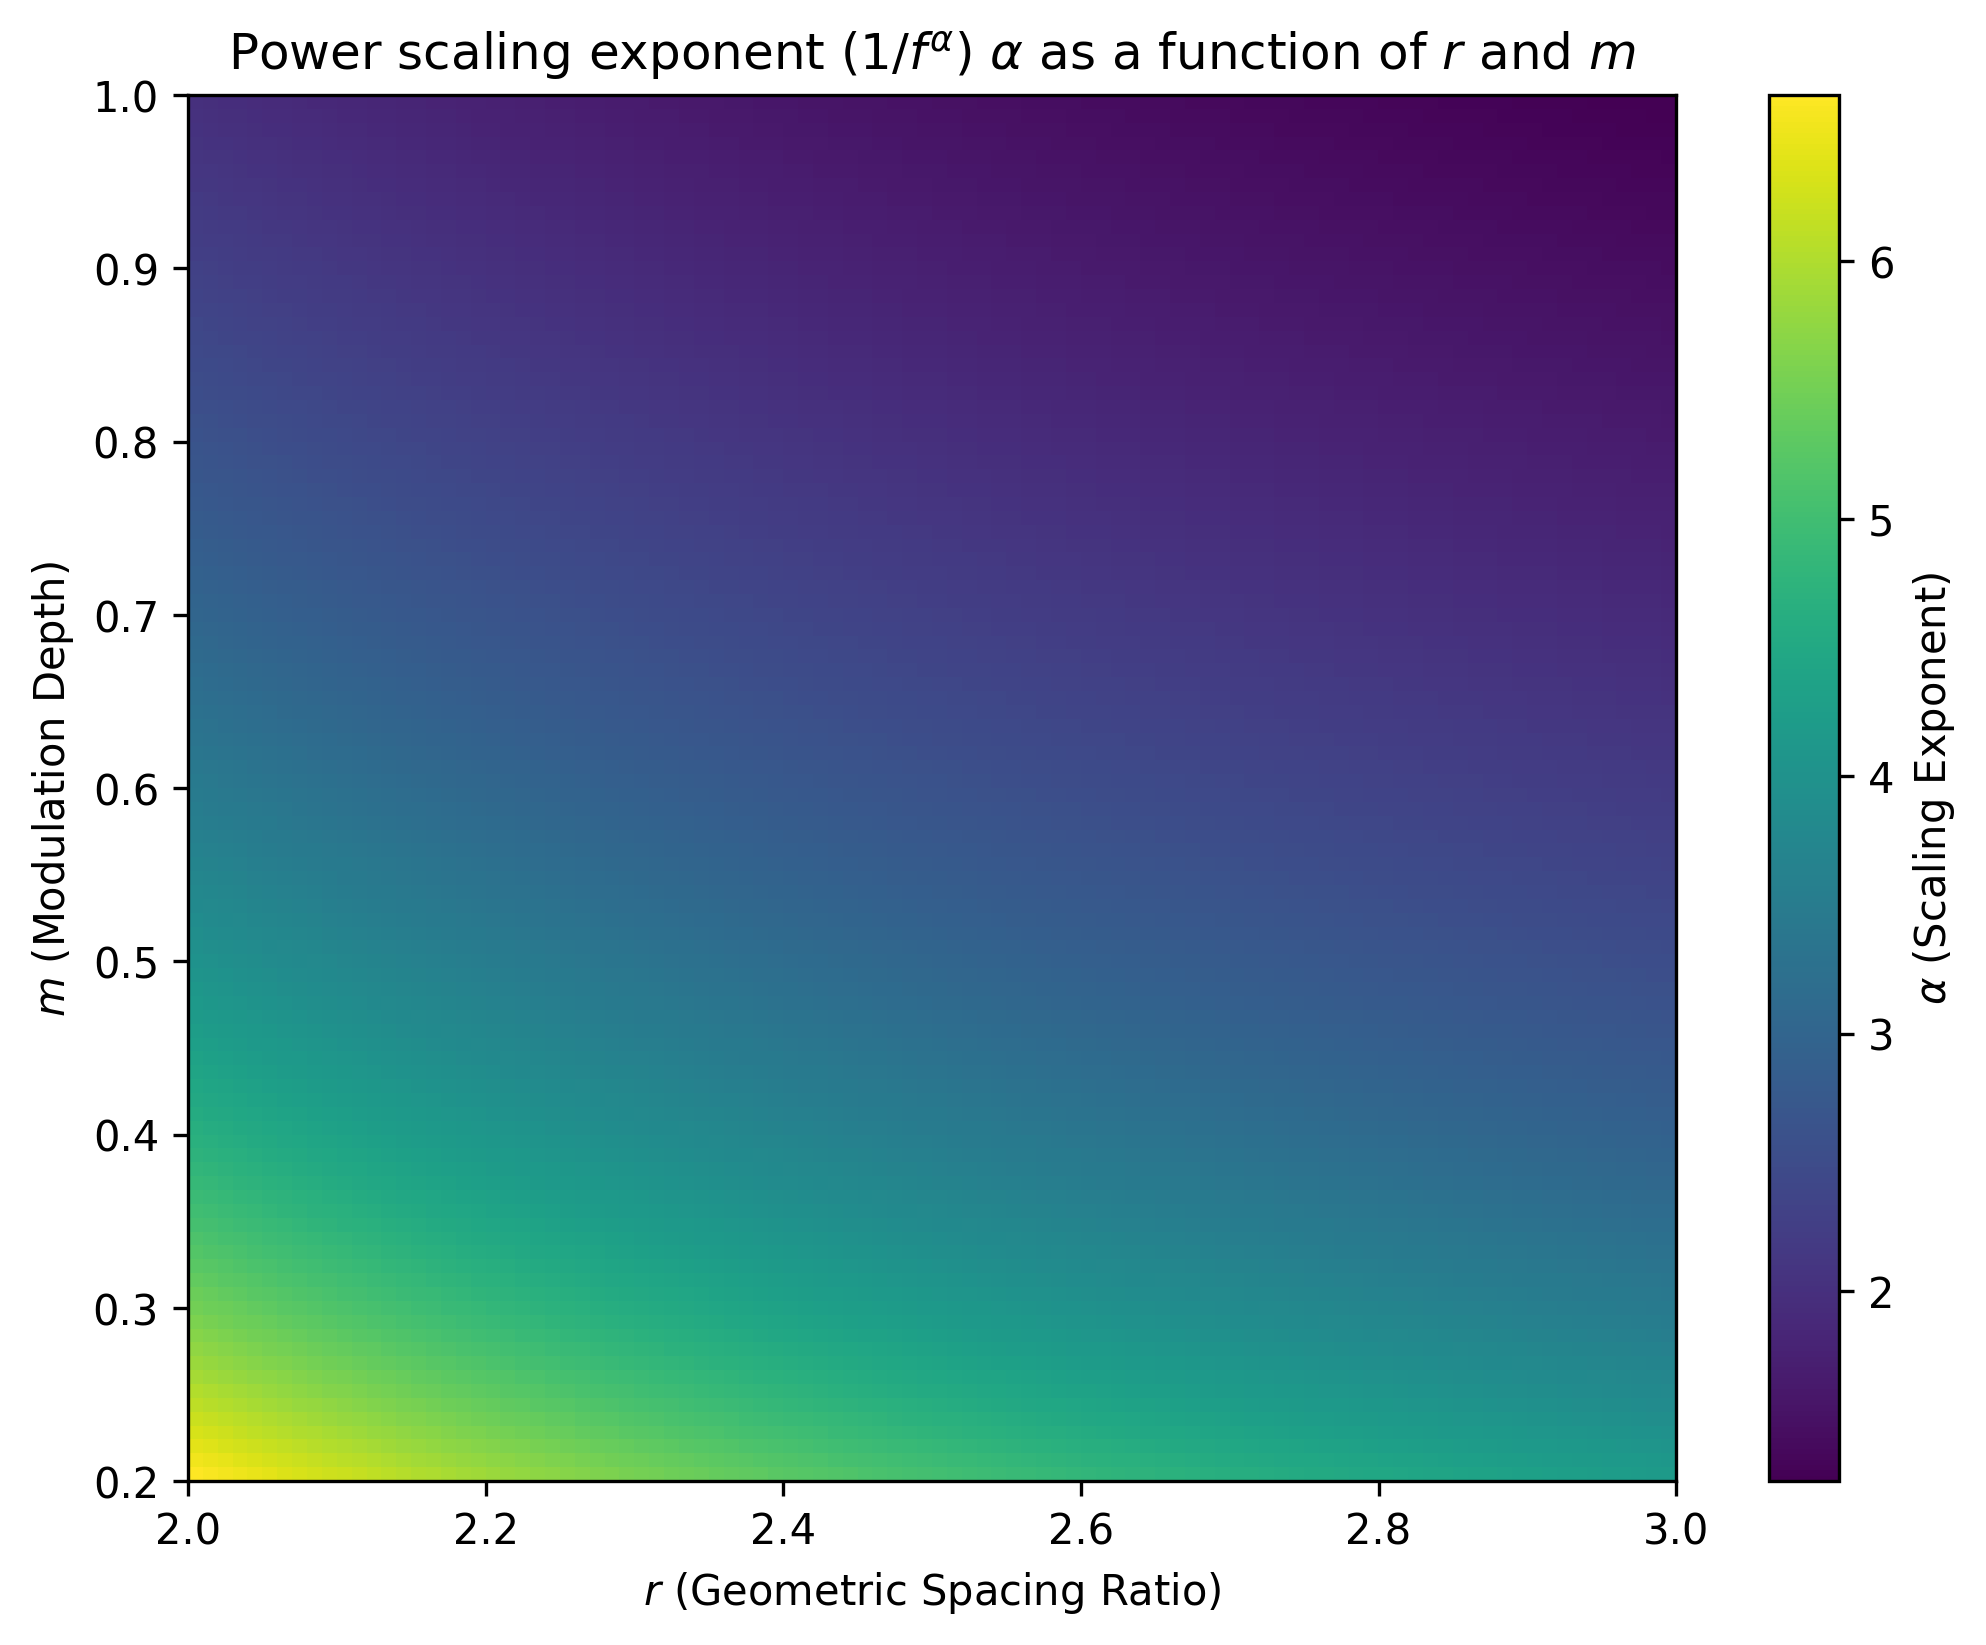

In [2]:
import numpy as np
import matplotlib.pyplot as plt

# Define ranges for r and m
r_values = np.linspace(2, 3, 100)  # Avoid r=0 or 1 to keep logarithm well-defined
m_values = np.linspace(0.2, 1, 100)  # Avoid m=0 or 1 to keep logarithm well-defined

# Compute alpha for each (r, m) pair
alpha_values = np.zeros((len(m_values), len(r_values)))

for i, m in enumerate(m_values):
    for j, r in enumerate(r_values):
        alpha_values[i, j] = (2 * np.log(2 / m)) / np.log(r)

# Create heatmap
plt.figure(figsize=(8, 6))
plt.imshow(alpha_values, aspect='auto', origin='lower',
           extent=[r_values[0], r_values[-1], m_values[0], m_values[-1]],
           cmap='viridis')

# Labels and colorbar
plt.colorbar(label=r'$\alpha$ (Scaling Exponent)')
plt.xlabel(r'$r$ (Geometric Spacing Ratio)')
plt.ylabel(r'$m$ (Modulation Depth)')
plt.title(r'Power scaling exponent ($1/f^\alpha$) $\alpha$ as a function of $r$ and $m$')

plt.show()

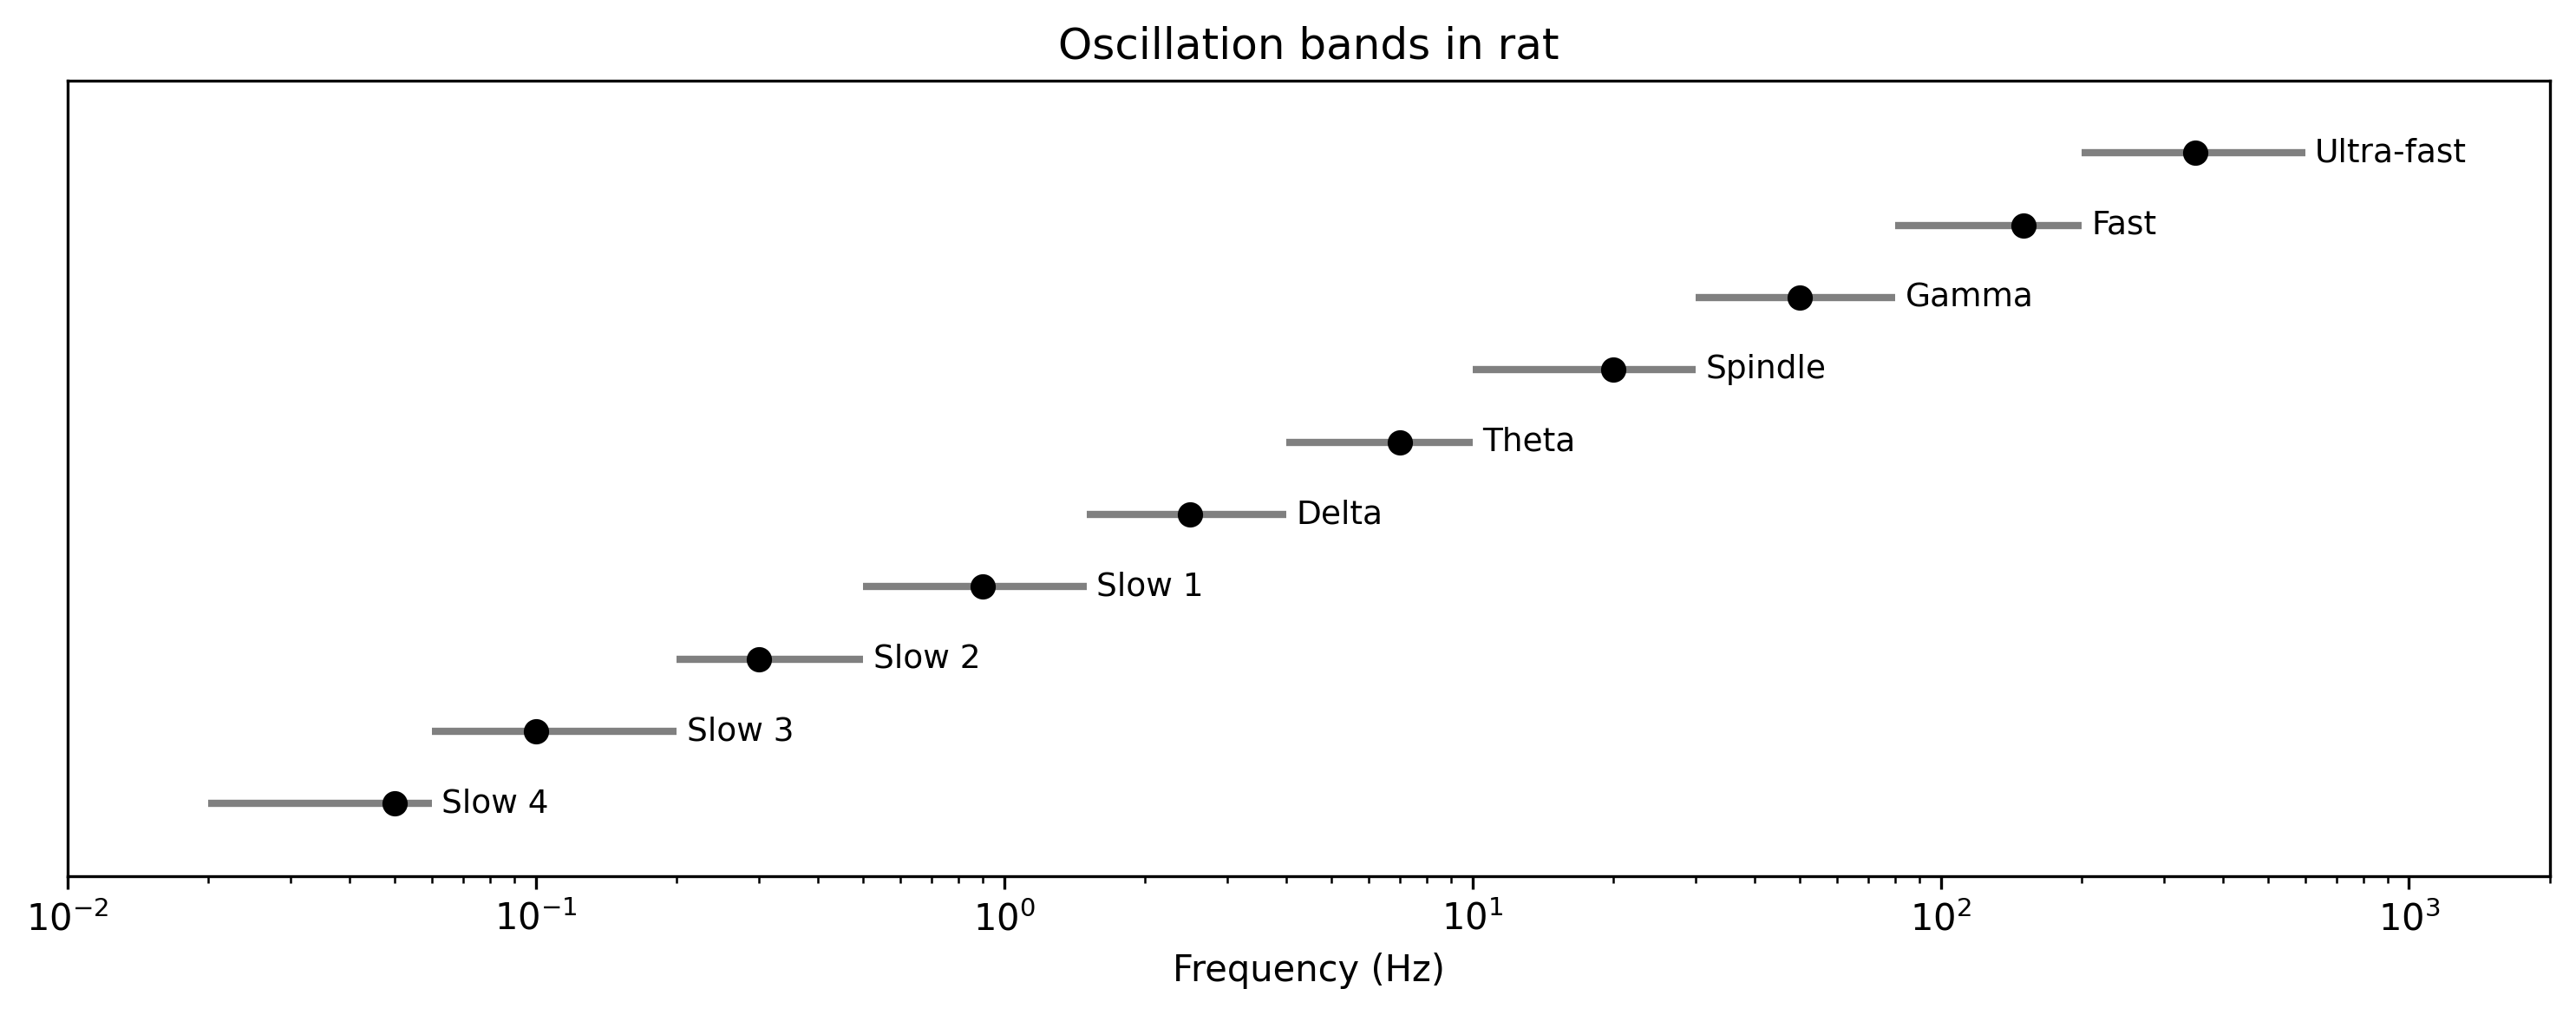

In [3]:
import matplotlib.pyplot as plt

# Oscillation bands from Penttonen & Buzsáki (2003)
bands = [
    {
        "name": "Slow 4",
        "number": 1,
        "center_frequency_hz": 0.05,
        "frequency_range_hz": (0.02, 0.06),
        "period_range_s": (15, 40)
    },
    {
        "name": "Slow 3",
        "number": 2,
        "center_frequency_hz": 0.1,
        "frequency_range_hz": (0.06, 0.2),
        "period_range_s": (5, 15)
    },
    {
        "name": "Slow 2",
        "number": 3,
        "center_frequency_hz": 0.3,
        "frequency_range_hz": (0.2, 0.5),
        "period_range_s": (2, 5)
    },
    {
        "name": "Slow 1",
        "number": 4,
        "center_frequency_hz": 0.9,
        "frequency_range_hz": (0.5, 1.5),
        "period_range_s": (0.7, 2.0)
    },
    {
        "name": "Delta",
        "number": 5,
        "center_frequency_hz": 2.5,
        "frequency_range_hz": (1.5, 4.0),
        "period_range_s": (0.25, 0.7)
    },
    {
        "name": "Theta",
        "number": 6,
        "center_frequency_hz": 7.0,
        "frequency_range_hz": (4.0, 10.0),
        "period_range_s": (0.1, 0.25)
    },
    {
        "name": "Spindle",
        "number": 7,
        "center_frequency_hz": 20.0,
        "frequency_range_hz": (10.0, 30.0),
        "period_range_s": (0.03, 0.1)
    },
    {
        "name": "Gamma",
        "number": 8,
        "center_frequency_hz": 50.0,
        "frequency_range_hz": (30.0, 80.0),
        "period_range_s": (0.01, 0.03)
    },
    {
        "name": "Fast",
        "number": 9,
        "center_frequency_hz": 150.0,
        "frequency_range_hz": (80.0, 200.0),
        "period_range_s": (0.004, 0.01)
    },
    {
        "name": "Ultra-fast",
        "number": 10,
        "center_frequency_hz": 350.0,
        "frequency_range_hz": (200.0, 600.0),
        "period_range_s": (0.001, 0.004)
    }
]

def plot_penttonen_bands(bands):
    fig, ax = plt.subplots(figsize=(10, 4))

    # Plot each band as a horizontal line from fmin to fmax
    # with a marker at the center frequency
    for i, band in enumerate(bands):
        fmin, fmax = band["frequency_range_hz"]
        fc = band["center_frequency_hz"]
        label = band["name"]

        # Draw a horizontal line for the frequency range
        ax.hlines(y=i+1, xmin=fmin, xmax=fmax, color='grey', linewidth=2)
        # Mark the center frequency with a black dot
        ax.plot(fc, i+1, 'ko')
        # Add text label near the right endpoint
        ax.text(fmax*1.05, i+1, label, va='center', fontsize=9)

    ax.set_xlabel("Frequency (Hz)")
    ax.set_ylabel("Band Index")
    # The y-axis is just an integer index; no need for custom ticks
    ax.set_ylim(0, len(bands)+1)
    ax.set_xlim(0.01,2000)

       # Remove y-axis ticks and label
    ax.set_yticks([])  # Remove ticks
    ax.set_ylabel("")  # Remove label

    # Use a log scale for frequency
    ax.set_xscale('log')
    ax.set_title("Oscillation bands in rat")
    plt.tight_layout()
    plt.show()
# remove y ticks
plot_penttonen_bands(bands)

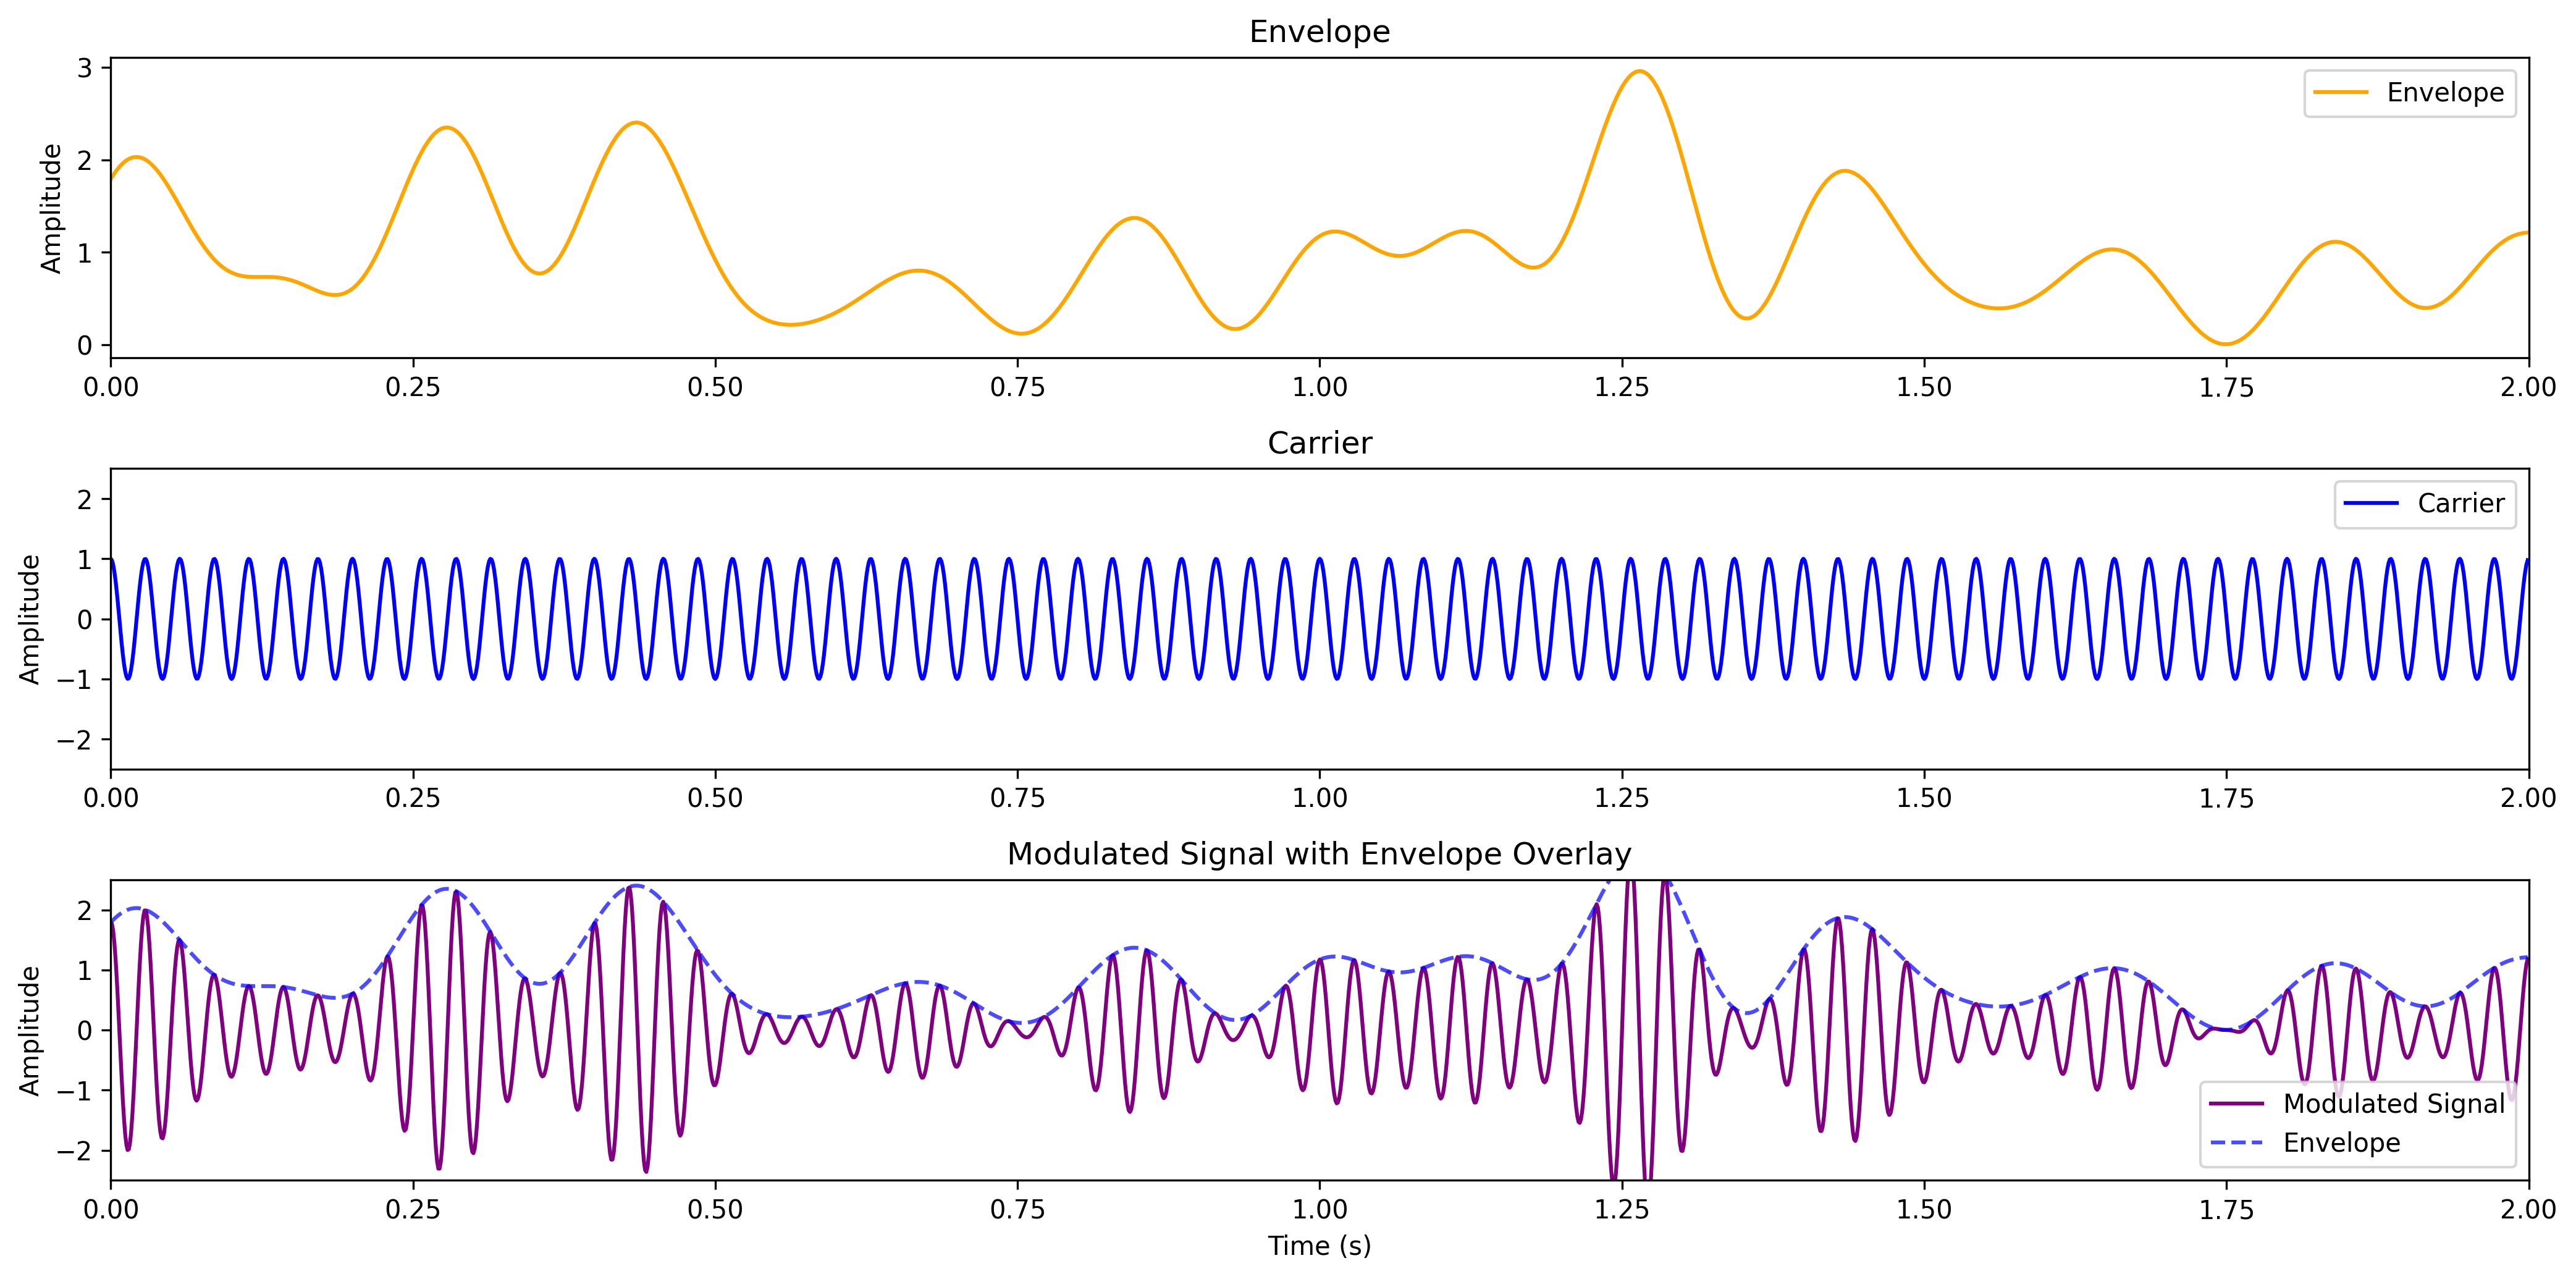

In [4]:
# prompt: I want a plain multi plot to demo AM radio showing 1) a slow envelope (a signal > 0)  at about 5 Hz, but with some bandwditth content to make it intersting (varyig in phase and amplitude).  2) a carrier at say at 40 Hz. Then  3) the product of envelope and carrier, with the envelope overlaid.

import numpy as np
import matplotlib.pyplot as plt

# Parameters
fs = 1000  # Sampling rate (Hz)
duration = 2  # Duration (seconds)
t = np.linspace(0, duration, int(fs * duration), endpoint=False)

# Frequencies
f_envelope = 5  # Envelope frequency (Hz)
f_carrier = 35  # Carrier frequency (Hz)

# Envelope (with some bandwidth)
envelope = 1 + 0.6 * np.sin(2 * np.pi * f_envelope * t) + 0.3 * np.cos(2 * np.pi * (f_envelope + 2.1) * t)+ 0.2 * np.cos(2 * np.pi * (f_envelope - 2.5) * t +0.1)
envelope = envelope+ 0.2 * np.cos(2 * np.pi * (f_envelope + 1.1) * t)+ 0.2 * np.cos(2 * np.pi * (f_envelope - 2.9) * t +1.1)
envelope = envelope * (1+0.5*np.sin(2 * np.pi  * t))
# Carrier
carrier = np.cos(2 * np.pi * f_carrier * t)

# Modulated signal
modulated_signal = envelope * carrier


# Plotting
plt.figure(figsize=(14, 7))

plt.subplot(3, 1, 1)
plt.plot(t, envelope, label='Envelope', color='orange')
plt.title('Envelope')
plt.ylabel('Amplitude')
plt.xlim(0, duration)
plt.legend()

plt.subplot(3, 1, 2)
plt.plot(t, carrier, label='Carrier', color='blue')
plt.title('Carrier')
plt.ylabel('Amplitude')
plt.xlim(0, duration)
plt.ylim(-2.5, 2.5)
plt.legend()

plt.subplot(3, 1, 3)
plt.plot(t, modulated_signal, label='Modulated Signal', color='purple')
plt.plot(t, envelope, label='Envelope', color='blue', linestyle='--', alpha=0.7)  # Overlay envelope
plt.title('Modulated Signal with Envelope Overlay')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.xlim(0, duration)
plt.ylim(-2.5, 2.5)
plt.legend()

plt.tight_layout()
plt.show()


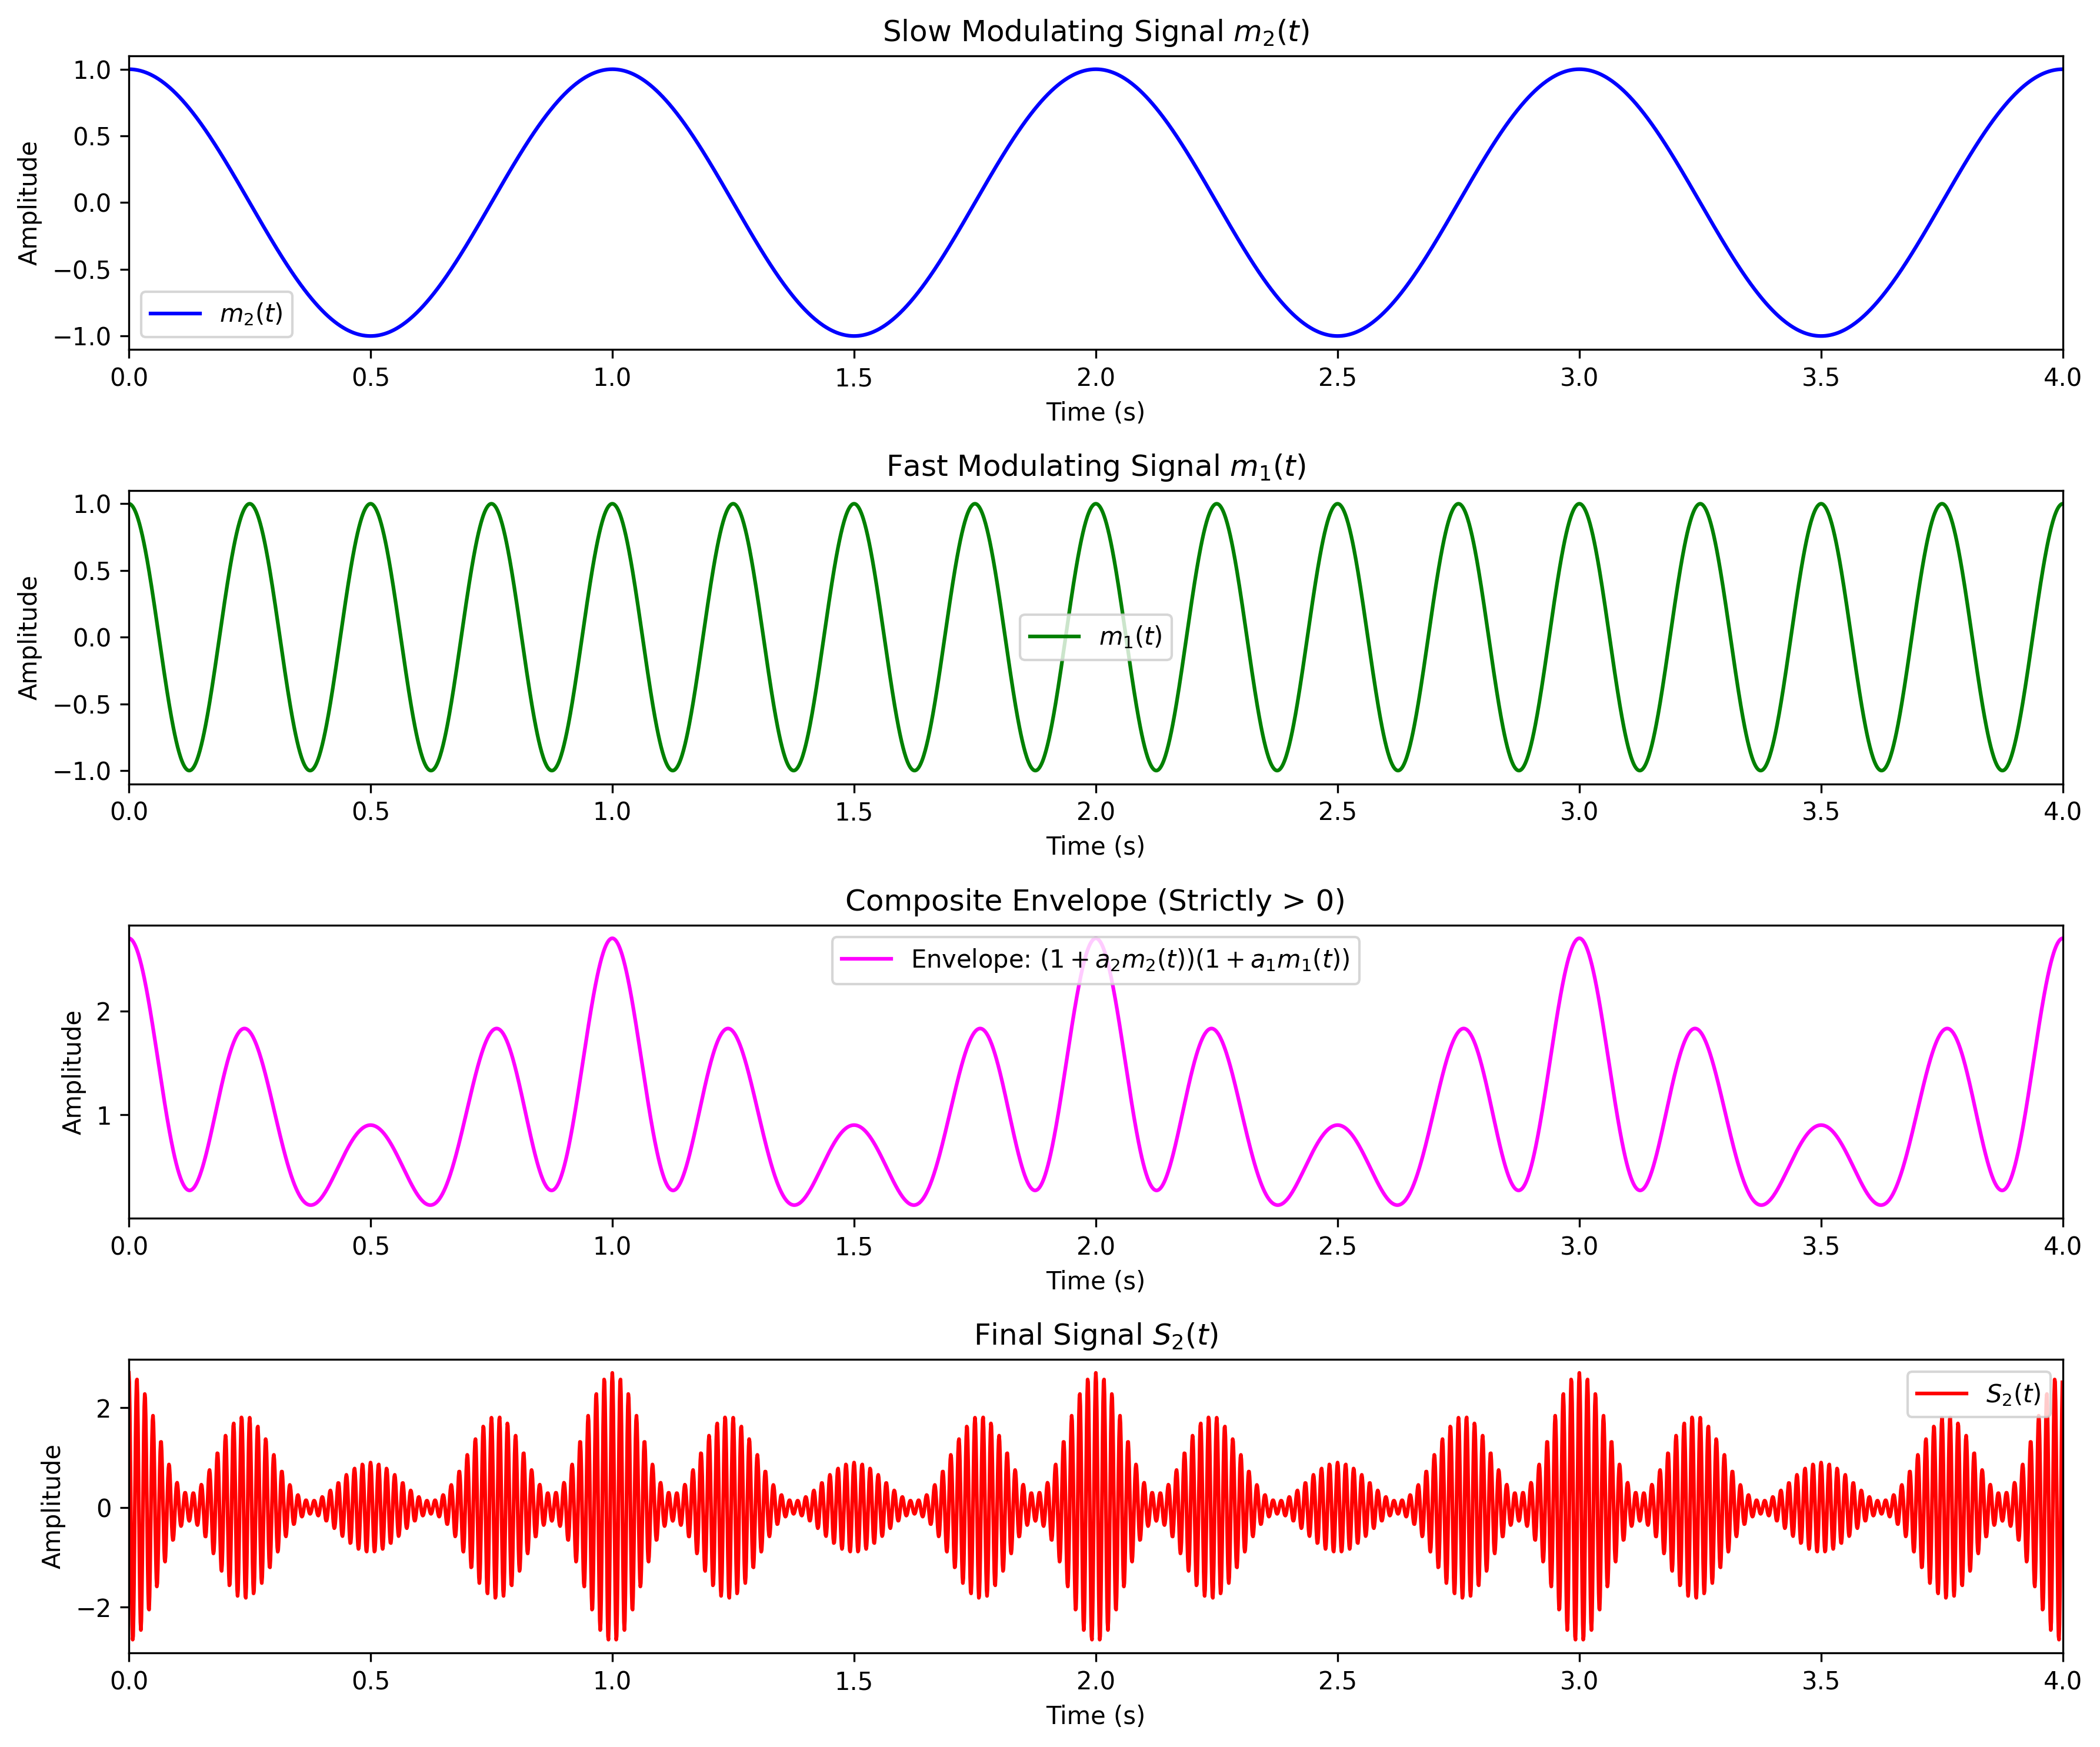

In [5]:
import numpy as np
import matplotlib.pyplot as plt

# Sampling parameters
fs = 1000             # Sampling rate (Hz)
duration = 4.0        # Duration in seconds
t = np.linspace(0, duration, int(fs * duration), endpoint=False)

# Frequencies
f_c   = 60.0  # Carrier frequency (Hz)
f_m1  = 4.0   # Frequency for m1(t) (fast modulator)
f_m2  = 1.0   # Frequency for m2(t) (slow modulator)

# Modulation parameters (choose a1, a2 < 1 to ensure positivity)
A_c = 1.0
a1 = 0.8  # amplitude of m1 modulation
a2 = 0.5  # amplitude of m2 modulation

# Define modulating signals (both range in [-1,1])
m1 = np.cos(2 * np.pi * f_m1 * t)  # Fast modulator
m2 = np.cos(2 * np.pi * f_m2 * t)  # Slow modulator

# Compute the composite envelope:
# Since m1 and m2 are cosines (i.e., between -1 and 1),
# the terms 1+a1*m1 and 1+a2*m2 remain > 0 as long as a1, a2 < 1.
envelope = (1 + a2 * m2) * (1 + a1 * m1)

# Construct the final signal S2(t)
S2 = A_c * envelope * np.cos(2 * np.pi * f_c * t)

# Plotting
plt.figure(figsize=(12, 10))

# Plot the slow modulator m2(t)
plt.subplot(4, 1, 1)
plt.plot(t, m2, label=r'$m_2(t)$', color='blue')
plt.title("Slow Modulating Signal $m_2(t)$")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.legend()
plt.xlim([0, duration])

# Plot the fast modulator m1(t)
plt.subplot(4, 1, 2)
plt.plot(t, m1, label=r'$m_1(t)$', color='green')
plt.title("Fast Modulating Signal $m_1(t)$")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.legend()
plt.xlim([0, duration])

# Plot the composite envelope
plt.subplot(4, 1, 3)
plt.plot(t, envelope, label=r'Envelope: $(1+a_2m_2(t))(1+a_1m_1(t))$', color='magenta')
plt.title("Composite Envelope (Strictly > 0)")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.legend()
plt.xlim([0, duration])

# Plot the final signal S2(t)
plt.subplot(4, 1, 4)
plt.plot(t, S2, label=r'$S_2(t)$', color='red')
plt.title("Final Signal $S_2(t)$")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.legend()
plt.xlim([0, duration])

plt.tight_layout()
plt.show()

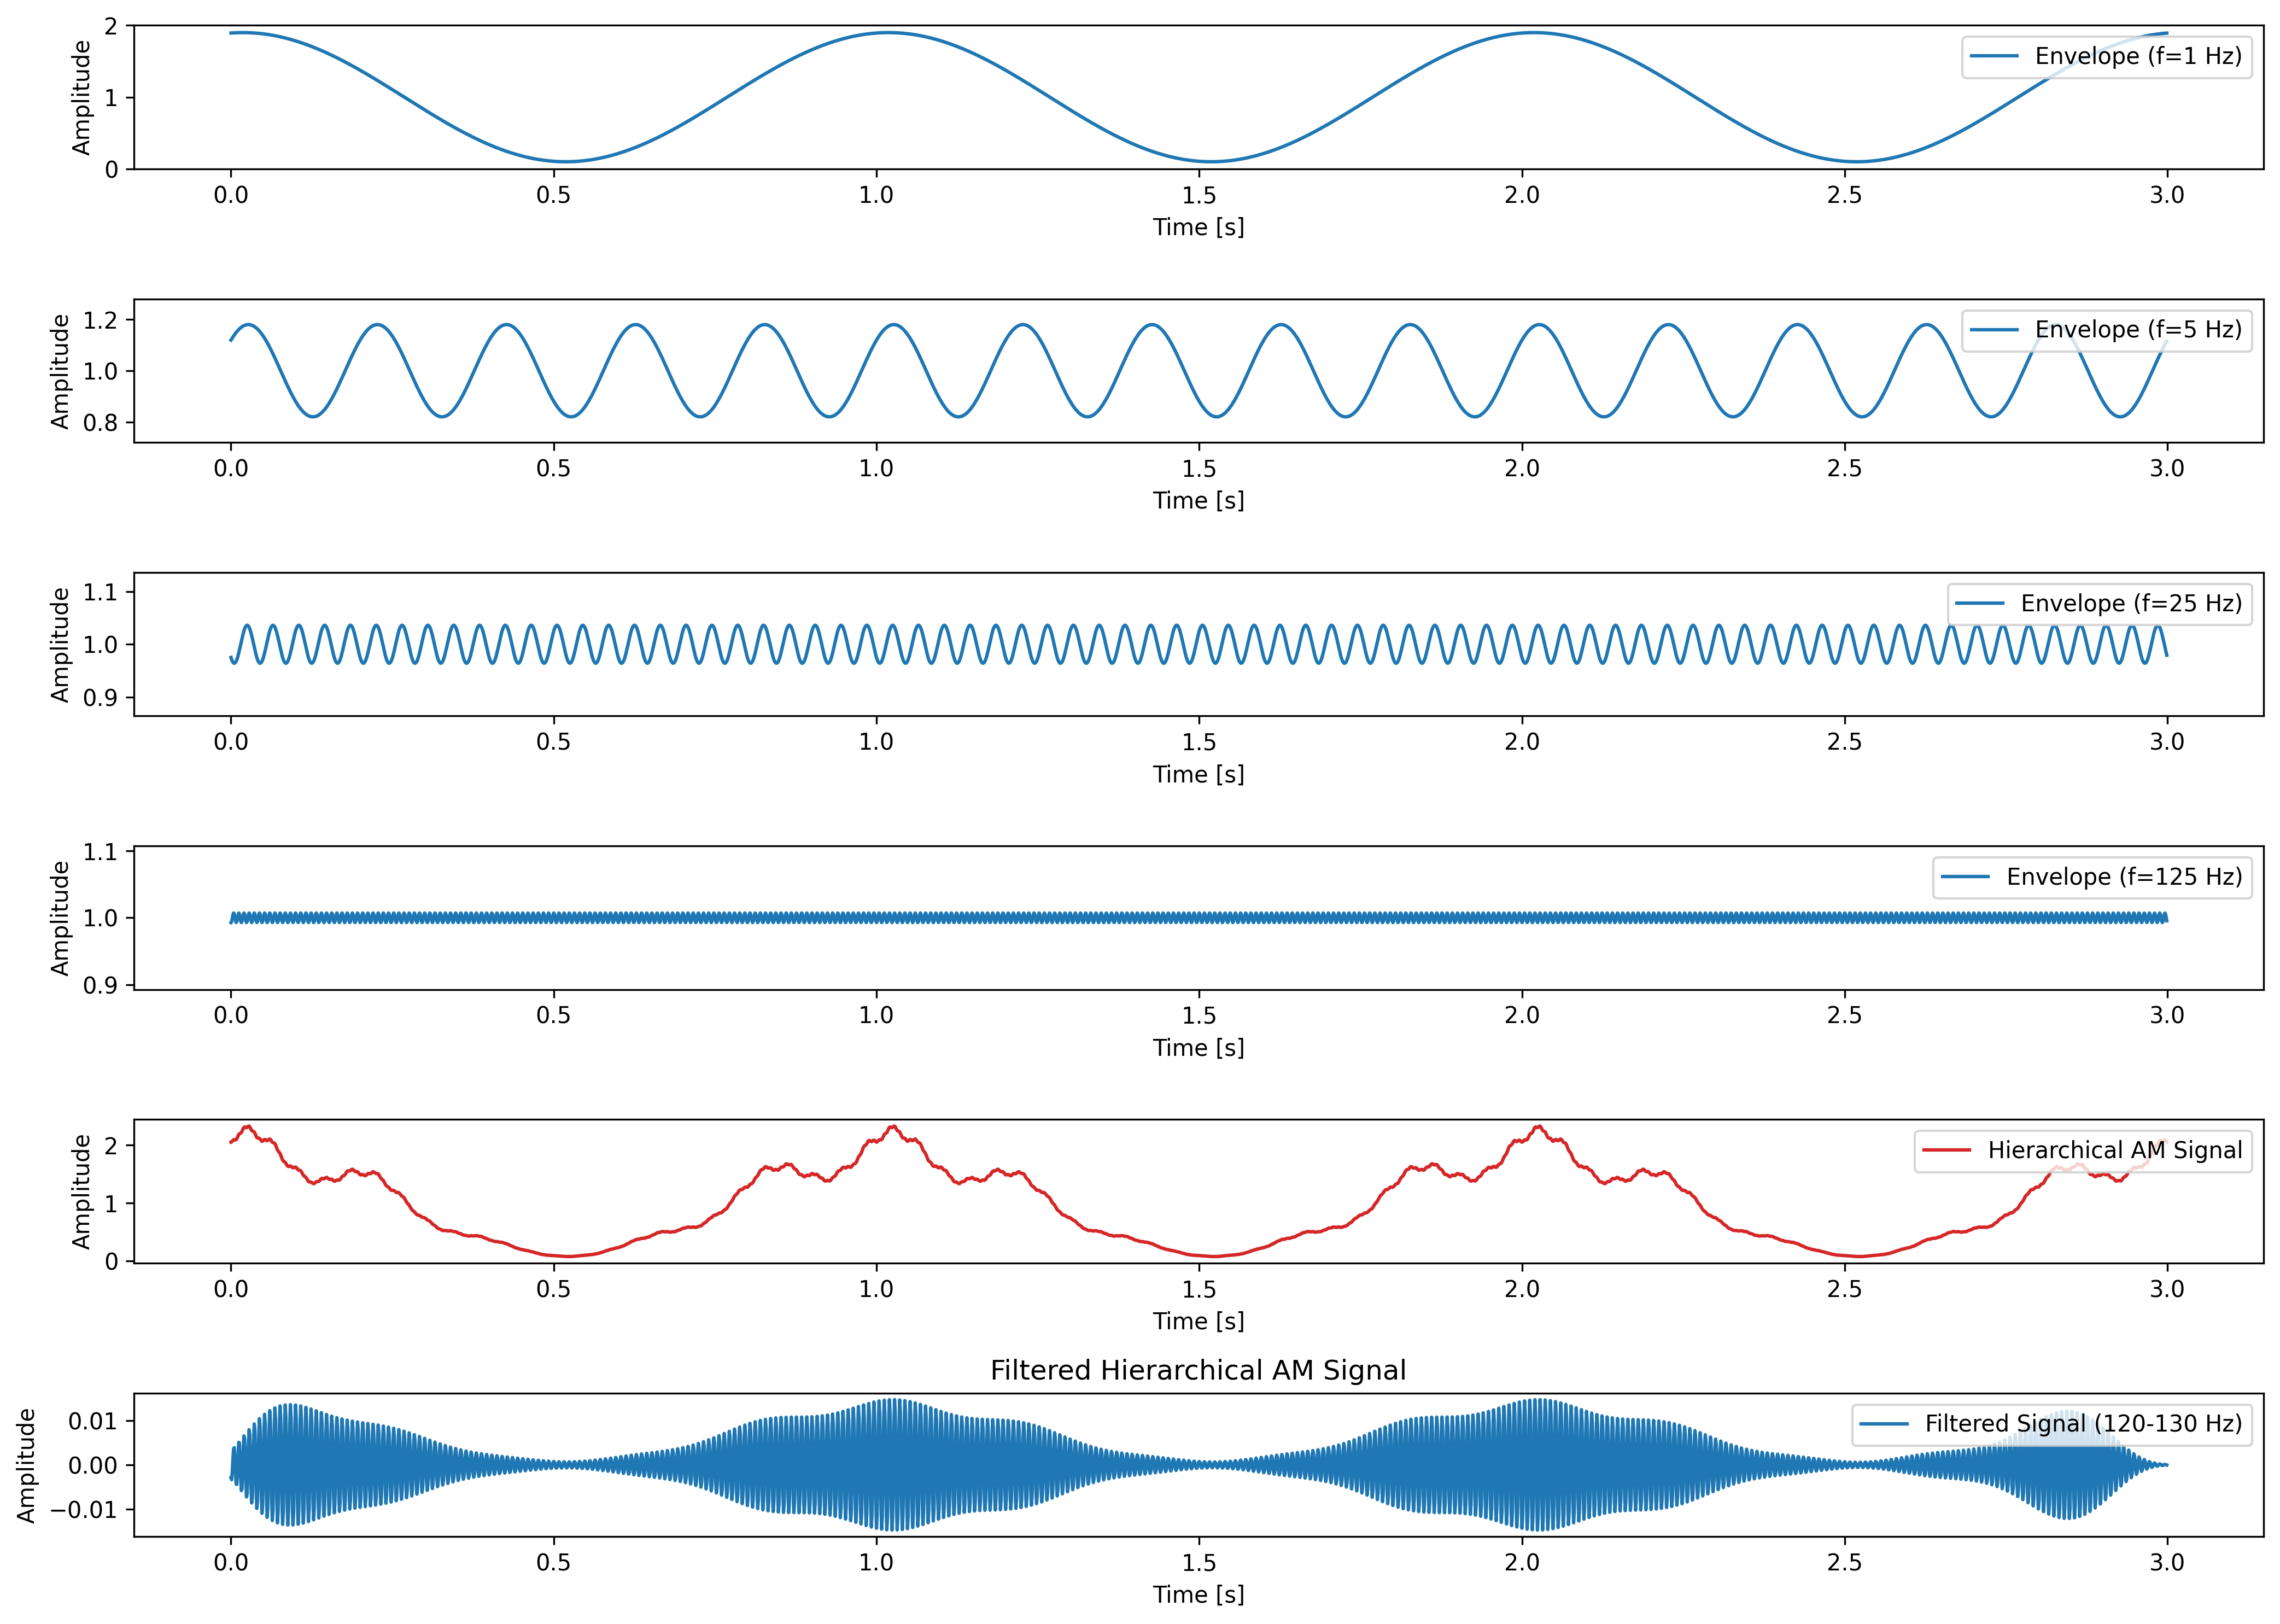

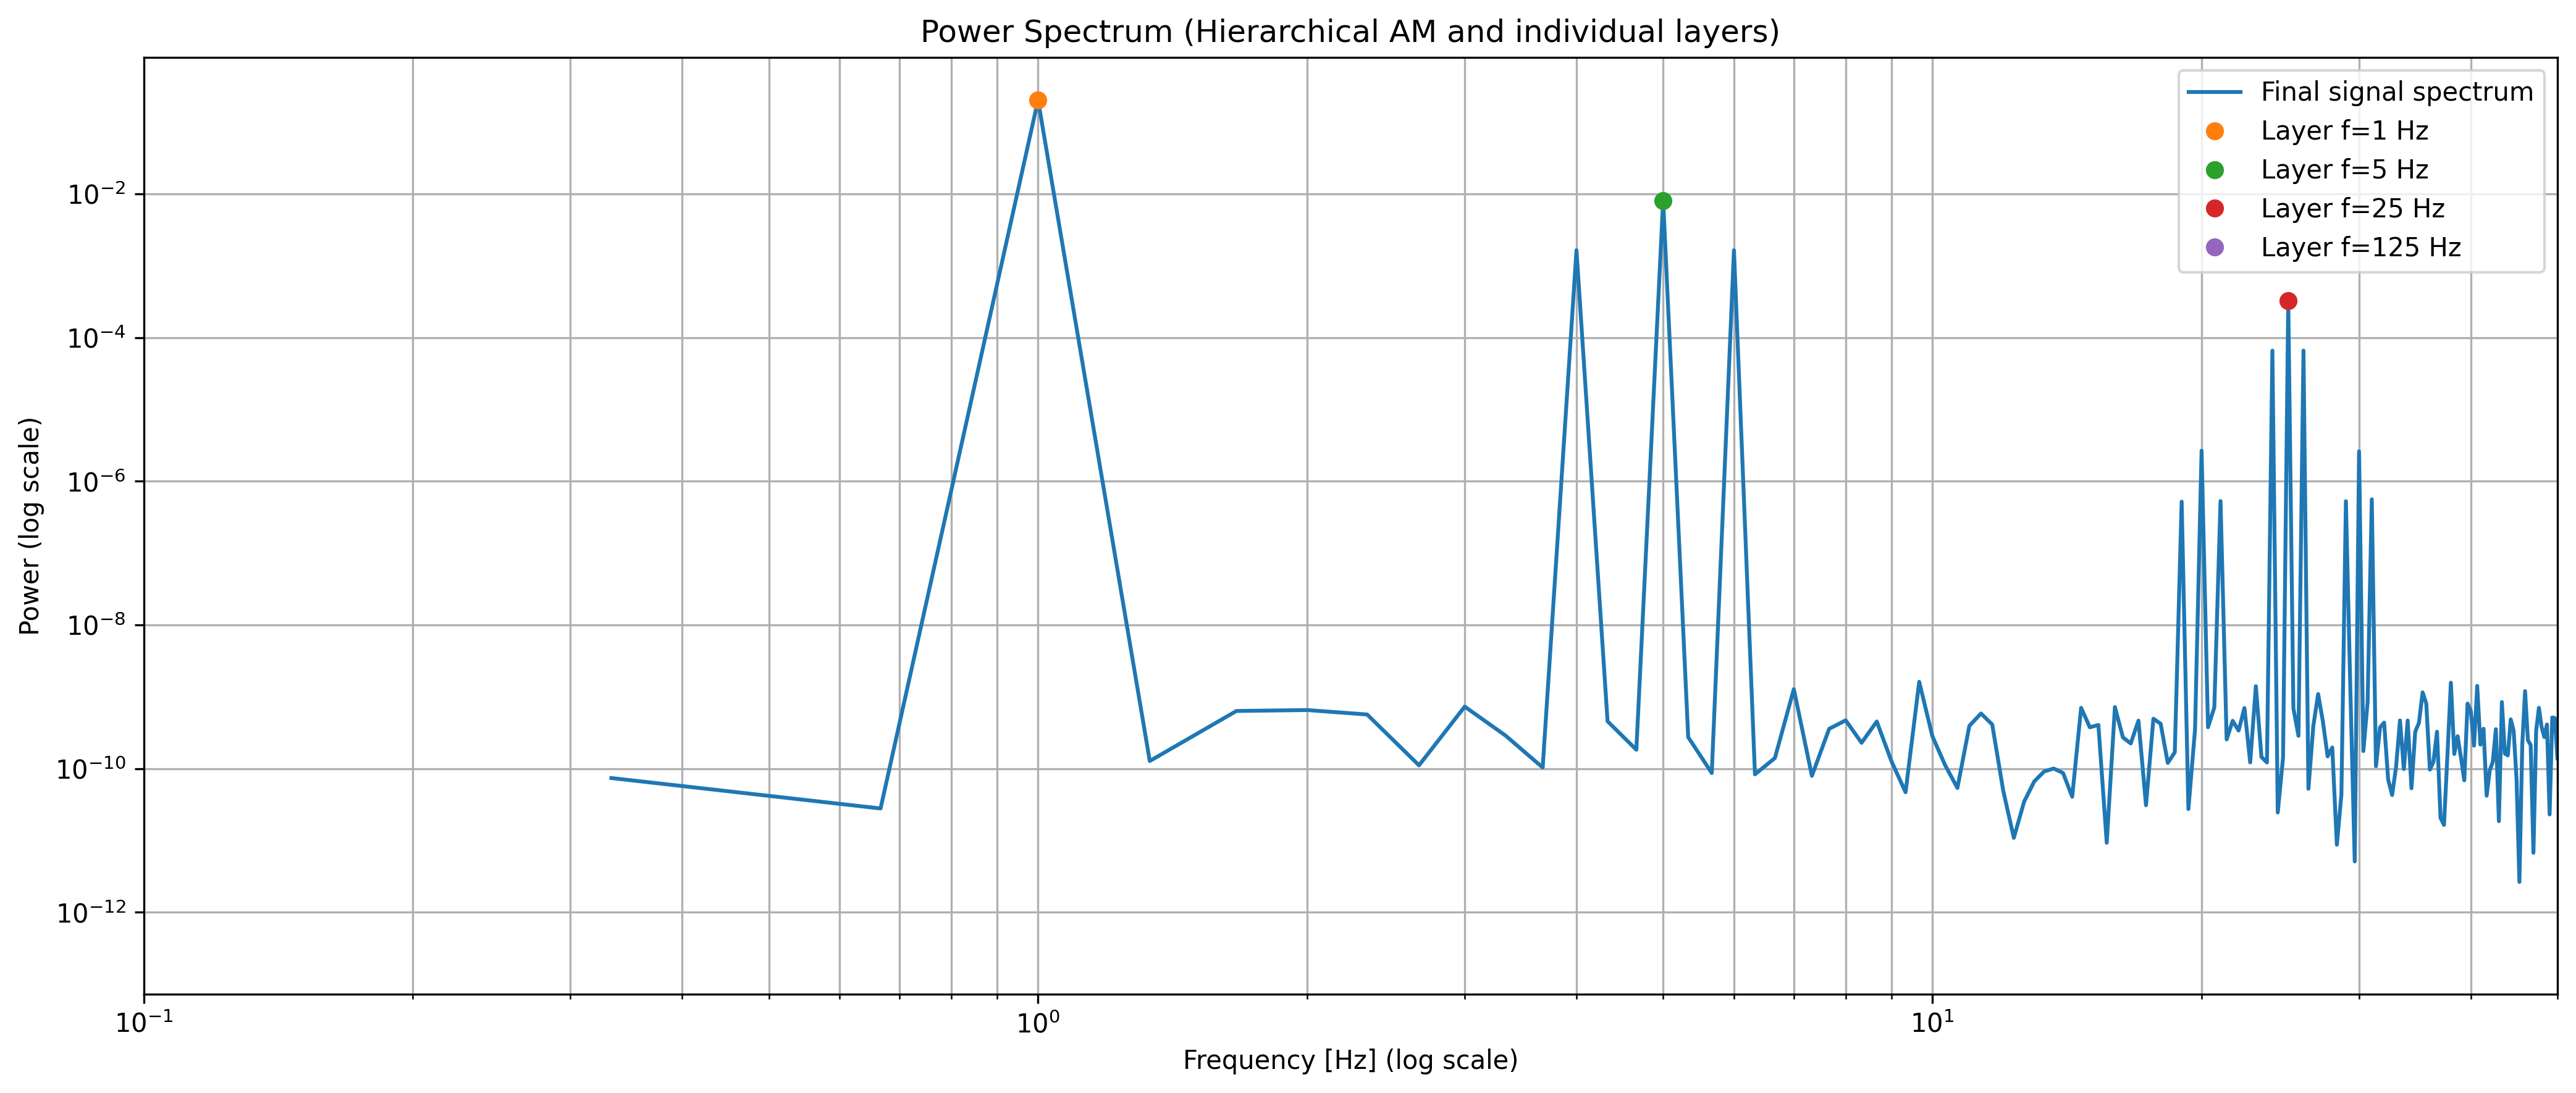

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import hilbert, butter, filtfilt

# 1. Define hierarchical modulation parameters
frequencies = np.array([1, 4, 16, 64])
frequencies = np.array([1, 5, 25, 125])           # modulation frequencies (Hz), chosen to be well-separated
amp_factor = 0.9                                  # scaling factor for modulation depths
amplitudes = amp_factor / frequencies             # m_i = 0.9 / f_i -> ensures m_i ~ 1/f_i (power ~ 1/f^2)
phases = 2 * np.pi * np.random.rand(len(frequencies))  # random phases φ_i in [0, 2π)

# 2. Generate time array (sampling rate and duration)
fs = 1000.0             # sampling rate in Hz (must be > 2*highest frequency for Nyquist)
T  = 3.0                # duration in seconds (covers multiple cycles of lowest freq)
t  = np.arange(0, T, 1/fs)  # time vector from 0 to T with step 1/fs

# 3. Generate each modulation layer (envelope) as 1 + m_i * cos(2π f_i t + φ_i)
envelopes = []  # to store each envelope signal
for f, m, phi in zip(frequencies, amplitudes, phases):
    envelope = 1 + m * np.cos(2 * np.pi * f * t + phi)
    envelopes.append(envelope)

# 4. Construct the hierarchical signal by multiplying all envelopes
# Start with an array of ones and multiply each envelope into it
hierarchical_signal = np.ones_like(t)
for envelope in envelopes:
    hierarchical_signal *= envelope

# 5. Plot time-domain signals (envelopes and final signal)

# Function to apply a bandpass filter
def bandpass_filter(signal, lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    y = filtfilt(b, a, signal)
    return y

# Define highest carrier frequency and filtering range
highest_carrier = 125  # Hz
lowcut = highest_carrier - 5  # 120 Hz
highcut = highest_carrier + 5  # 130 Hz
filtered_signal = bandpass_filter(hierarchical_signal, lowcut, highcut, fs)

# Plot time-domain signals (envelopes, final signal, and filtered signal)
plt.figure(figsize=(14, 10))
num_layers = len(envelopes)

# Plot individual envelopes
for i, envelope in enumerate(envelopes, start=1):
    plt.subplot(num_layers+2, 1, i)  # Adding +2 to include the filtered plot
    plt.plot(t, envelope, label=f'Envelope (f={frequencies[i-1]} Hz)')
    plt.ylim(1 - amplitudes[i-1] - 0.1, 1 + amplitudes[i-1] + 0.1)  # Zoom y-axis
    plt.xlabel('Time [s]')
    plt.ylabel('Amplitude')
    plt.legend(loc='upper right')

# Plot the final hierarchical AM signal
plt.subplot(num_layers+2, 1, num_layers+1)
plt.plot(t, hierarchical_signal, color='C3', label='Hierarchical AM Signal')
plt.xlabel('Time [s]')
plt.ylabel('Amplitude')
plt.legend(loc='upper right')

# Plot the filtered signal around the highest carrier
plt.subplot(num_layers+2, 1, num_layers+2)
plt.plot(t, filtered_signal, label=f'Filtered Signal ({lowcut}-{highcut} Hz)', color='C0')
plt.xlabel('Time [s]')
plt.ylabel('Amplitude')
plt.title('Filtered Hierarchical AM Signal')
plt.legend(loc='upper right')

plt.tight_layout()
plt.show()



# 6. Compute and plot power spectra on log-log scale

# Add white noise to the final hierarchical signal
noise_power = 0.000001  # Adjust the noise power as needed
noise = np.random.normal(0, np.sqrt(noise_power), len(hierarchical_signal))
hierarchical_signal = hierarchical_signal + noise




# Filtering around the highest carrier frequency
def bandpass_filter(signal, lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    y = filtfilt(b, a, signal)
    return y

# Example usage: Filter around the highest carrier (125 Hz in this example)
highest_carrier = 125
lowcut = highest_carrier - 5 # 120 Hz
highcut = highest_carrier + 5 # 130 Hz
filtered_signal = bandpass_filter(hierarchical_signal, lowcut, highcut, fs)





# Use FFT to get power spectra
N = len(t)
freq_axis = np.fft.rfftfreq(N, d=1/fs)            # positive frequency axis for N-point FFT
power_final = np.abs(np.fft.rfft(hierarchical_signal)/N)**2  # power spectrum of final signal
power_envelopes = [np.abs(np.fft.rfft(env)/N)**2 for env in envelopes]  # list of power spectra for each envelope

plt.figure(figsize=(14, 6))
# Plot power spectrum of the final signal
plt.loglog(freq_axis[1:], power_final[1:], label='Final signal spectrum')  # [1:] to skip the 0 Hz bin for log scale
# Plot each envelope's spectrum (they have a DC component at 0 Hz and a peak at f_i)
for i, power_env in enumerate(power_envelopes):
    # Mark the modulator frequency peak for each layer
    f_idx = int(frequencies[i] * T)  # index of the frequency bin (because f_i * T is an integer number of cycles)
    plt.loglog(freq_axis[f_idx:f_idx+1], power_env[f_idx:f_idx+1], 'o',
               label=f'Layer f={frequencies[i]} Hz')
plt.xlabel('Frequency [Hz] (log scale)')
plt.xlim(0.1,50)
plt.ylabel('Power (log scale)')
plt.title('Power Spectrum (Hierarchical AM and individual layers)')
plt.legend()
plt.grid(True, which='both')
plt.tight_layout()
plt.show()

N= 1  r_min,strong=2.000000   r_min,super-increasing=2.000000
N= 2  r_min,strong=2.732051   r_min,super-increasing=1.618034
N= 3  r_min,strong=2.919640   r_min,super-increasing=1.839287
N= 4  r_min,strong=2.974449   r_min,super-increasing=1.927562
N= 5  r_min,strong=2.991654   r_min,super-increasing=1.965948
N= 6  r_min,strong=2.997241   r_min,super-increasing=1.983583


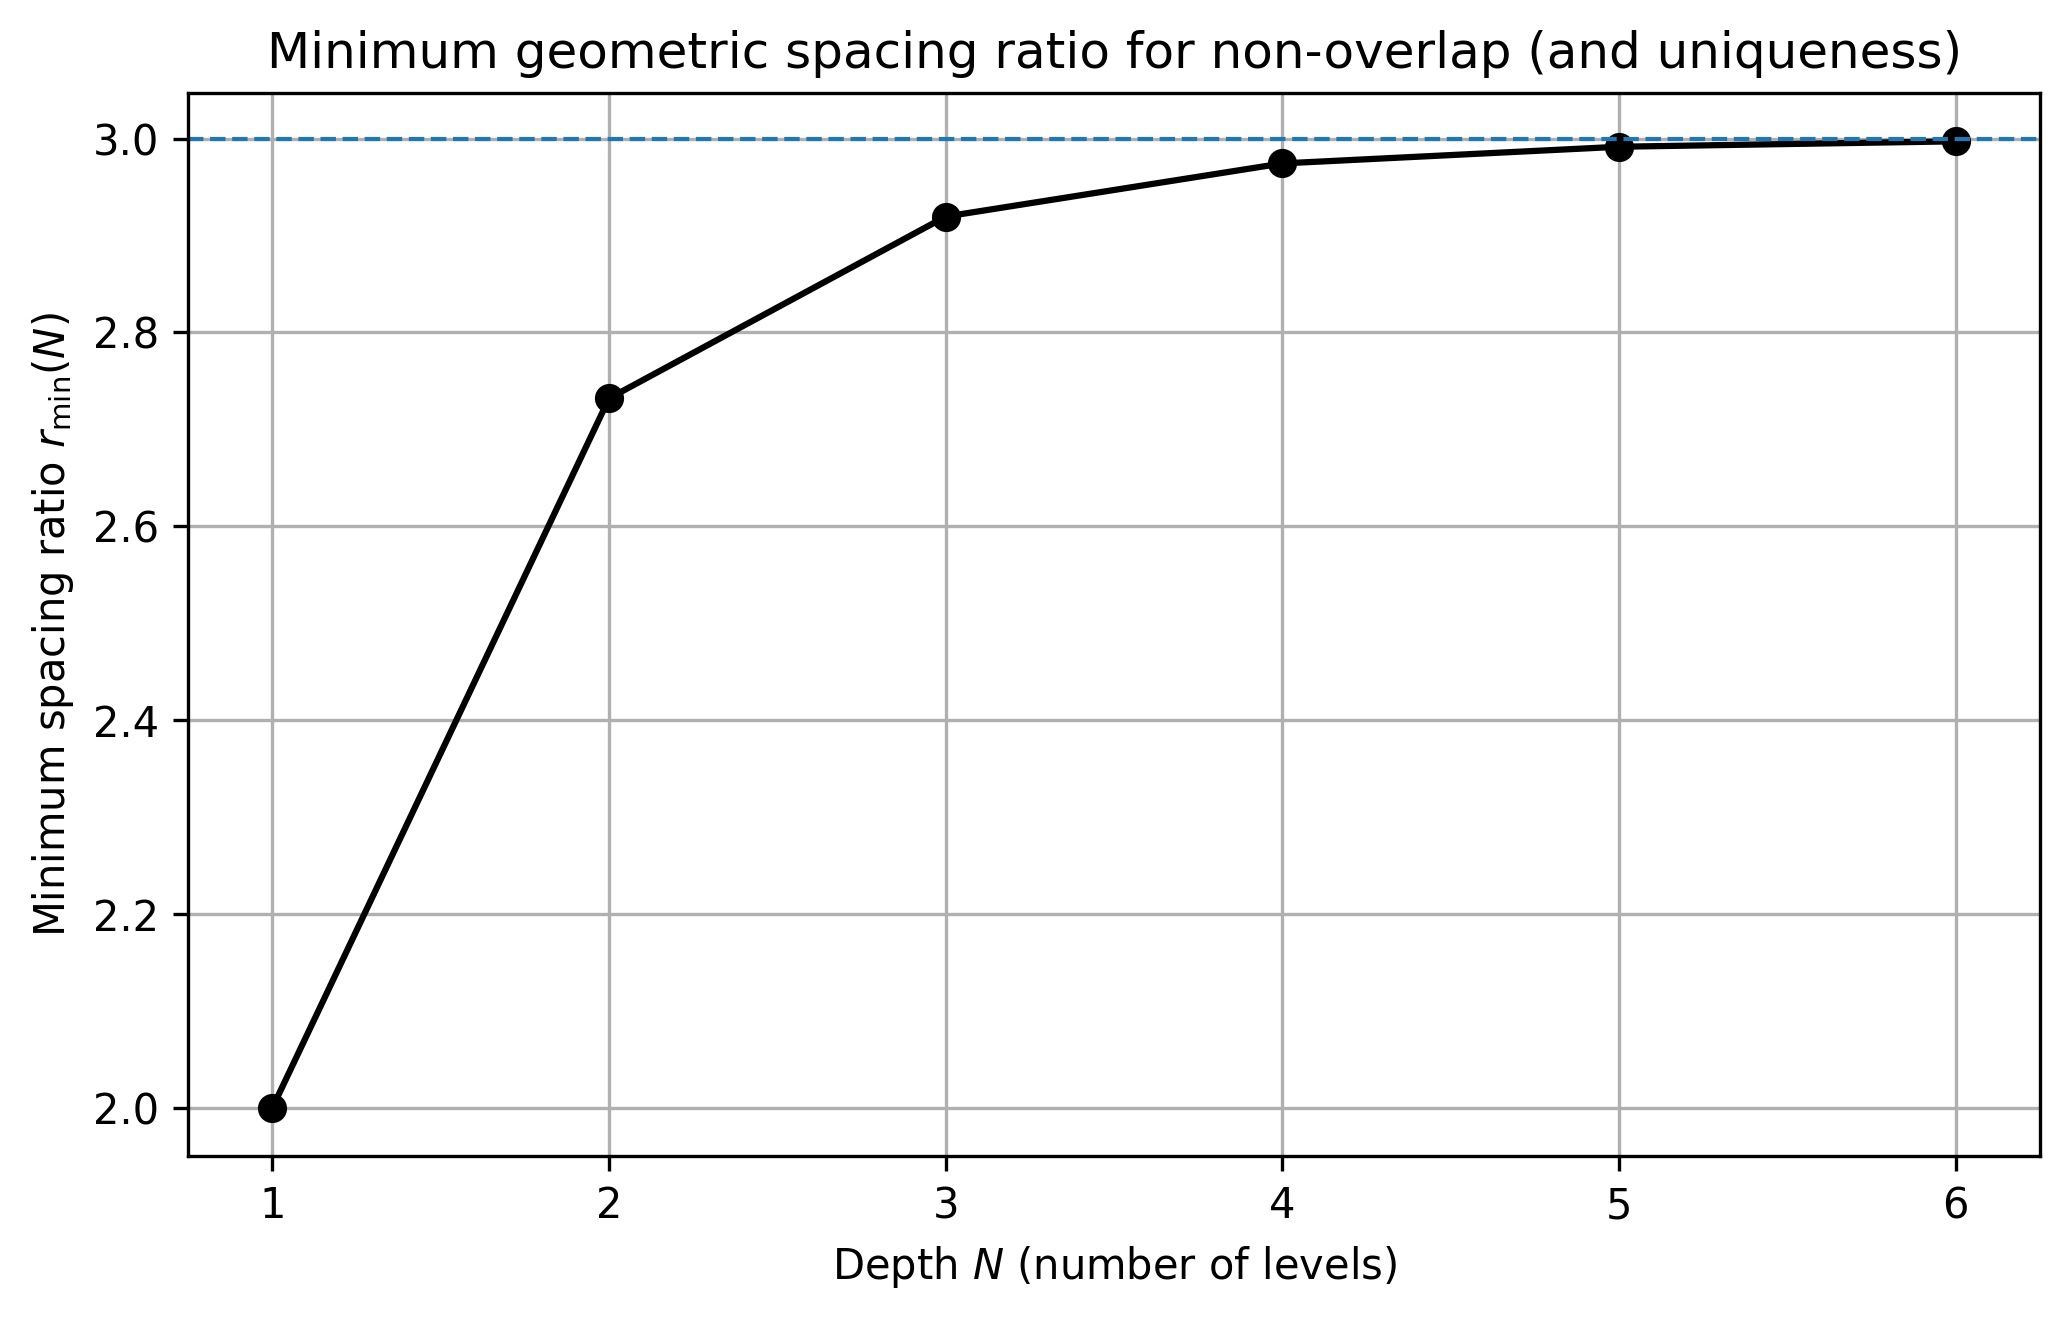

In [8]:
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 300  # Adjust to your preference
def rmin_strong(N, tol=1e-12):
    """Solve r = 3 - 2 r^{-N} for r in (1,3) by bisection."""
    a, b = 1.0 + 1e-12, 3.0
    f = lambda r: r - (3.0 - 2.0 * r**(-N))
    fa, fb = f(a), f(b)
    for _ in range(200):
        m = 0.5*(a+b)
        fm = f(m)
        if abs(fm) < tol or (b-a) < tol:
            return m
        if fa*fm < 0:
            b, fb = m, fm
        else:
            a, fa = m, fm
    return 0.5*(a+b)

def rmin_superincreasing(N, tol=1e-12):
    """Solve r = 2 - r^{-N} for r in (1,2) by bisection."""
    a, b = 1.0 + 1e-12, 2.0
    f = lambda r: r - (2.0 - r**(-N))
    fa, fb = f(a), f(b)
    for _ in range(200):
        m = 0.5*(a+b)
        fm = f(m)
        if abs(fm) < tol or (b-a) < tol:
            return m
        if fa*fm < 0:
            b, fb = m, fm
        else:
            a, fa = m, fm
    return 0.5*(a+b)

Ns = np.arange(1, 7)
r_strong = np.array([rmin_strong(int(N)) for N in Ns])
r_SI     = np.array([rmin_superincreasing(int(N)) for N in Ns])

# Print a small table
for N, rs, rsi in zip(Ns, r_strong, r_SI):
    print(f"N={N:2d}  r_min,strong={rs:.6f}   r_min,super-increasing={rsi:.6f}")

# Plot (one chart; default colors; no style settings)
plt.figure(figsize=(7,4.5))
plt.plot(Ns, r_strong, marker='o', label=r"Strong: $f_k>2\sum_{j>k} f_j$", color='k')
#plt.plot(Ns, r_SI, marker='s', label=r"Super-increasing: $f_k>\sum_{j>k} f_j$")
plt.axhline(3.0, linestyle='--', linewidth=1, label=r"$r\to 3$ (infinite depth, strong)")
#plt.axhline(2.0, linestyle='--', linewidth=1, label=r"$r\to 2$ (infinite depth, SI)")
plt.xlabel("Depth $N$ (number of levels)")
plt.ylabel(r"Minimum spacing ratio $r_{\min}(N)$")
plt.title("Minimum geometric spacing ratio for non-overlap (and uniqueness)")
plt.grid(True)
#plt.legend()
plt.tight_layout()
plt.show()
